In [27]:
import json
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

RESULTS_PATH = pathlib.Path("results.jsonl")


def load_results(path: pathlib.Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    visits, requests = [], []
    with path.open("r", encoding="utf-8") as handle:
        for line in handle:
            record = json.loads(line)
            visits.append(
                {
                    "visit_id": record["visit_id"],
                    "crawl_mode": record.get("crawl_mode"),
                    "consent_action": record.get("consent_action"),
                    "country": record.get("country"),
                    **record.get("summary", {}),
                }
            )
            for req in record.get("requests", []):
                requests.append(
                    {
                        "visit_id": record["visit_id"],
                        "crawl_mode": record.get("crawl_mode"),
                        "url": req.get("url"),
                        "status": req.get("status"),
                        "is_third_party": req.get("is_third_party"),
                        "disconnect_category": req.get("disconnect_category"),
                        "resourceType": req.get("resourceType"),
                        "blocked": req.get("blocked"),
                        "time": req.get("time"),
                    }
                )
    return pd.DataFrame(visits), pd.DataFrame(requests)

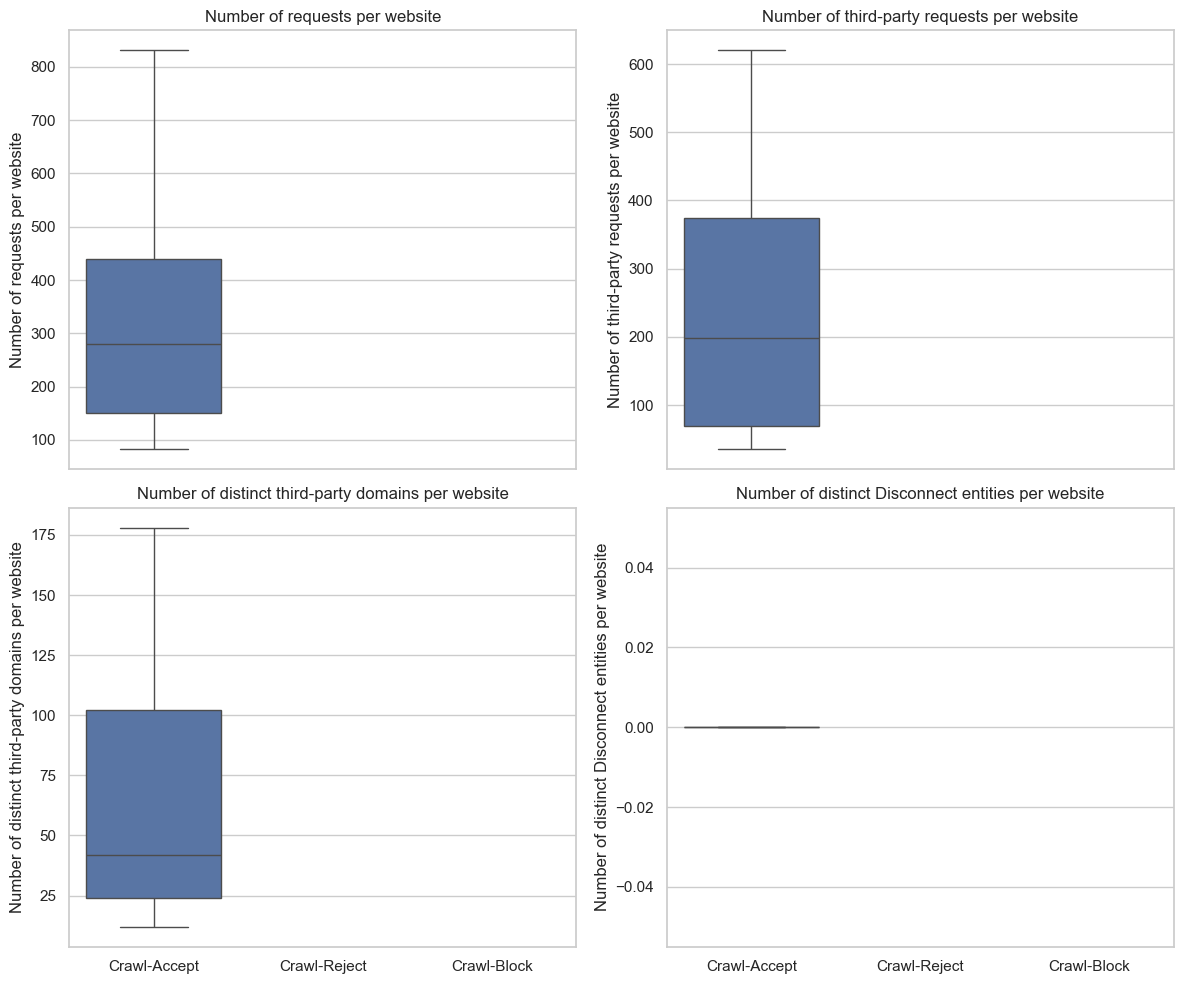

In [28]:
# 1

visits_df, _ = load_results(RESULTS_PATH)

label_map = {"accept": "Crawl-Accept", "reject": "Crawl-Reject", "block": "Crawl-Block"}
visits_df = visits_df.assign(
    crawl_label=visits_df["crawl_mode"].map(label_map),
    distinct_entities=visits_df["disconnect_category_counts"].apply(
        lambda d: len(d) if isinstance(d, dict) else 0
    ),
)

metrics = [
    ("total_requests", "Number of requests per website"),
    ("third_party_requests", "Number of third-party requests per website"),
    ("unique_domains_third_party", "Number of distinct third-party domains per website"),
    ("distinct_entities", "Number of distinct Disconnect entities per website"),
]

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)

for ax, (col, title) in zip(axes.flat, metrics):
    if col not in visits_df:
        raise KeyError(f"Missing summary column: {col}")
    sns.boxplot(
        data=visits_df,
        x="crawl_label",
        y=col,
        order=["Crawl-Accept", "Crawl-Reject", "Crawl-Block"],
        ax=ax,
    )
    ax.set_xlabel("")
    ax.set_ylabel(title)
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [29]:
# 2

metrics = {
    "total_requests": "Number of requests per website",
    "third_party_requests": "Number of third-party requests per website",
    "unique_domains_third_party": "Number of distinct third-party domains per website",
    "distinct_entities": "Number of distinct Disconnect entities per website",
}

stats = ["min", "median", "max"]

summary = (
    visits_df.groupby("crawl_label")[list(metrics.keys())]
    .agg(stats) # type: ignore
    .rename_axis(index="Crawl")
)

summary.columns = [f"{metrics[col]} – {stat.title()}" for col, stat in summary.columns]
summary

,Number of requests per website – Min,Number of requests per website – Median,Number of requests per website – Max,Number of third-party requests per website – Min,Number of third-party requests per website – Median,Number of third-party requests per website – Max,Number of distinct third-party domains per website – Min,Number of distinct third-party domains per website – Median,Number of distinct third-party domains per website – Max,Number of distinct Disconnect entities per website – Min,Number of distinct Disconnect entities per website – Median,Number of distinct Disconnect entities per website – Max
Crawl,,,,,,,,,,,,
Crawl-Accept,82,280.0,831,35,198.0,620,12,42.0,178,0,0.0,0


C:\Users\telle\AppData\Local\Temp\ipykernel_20632\2068598043.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


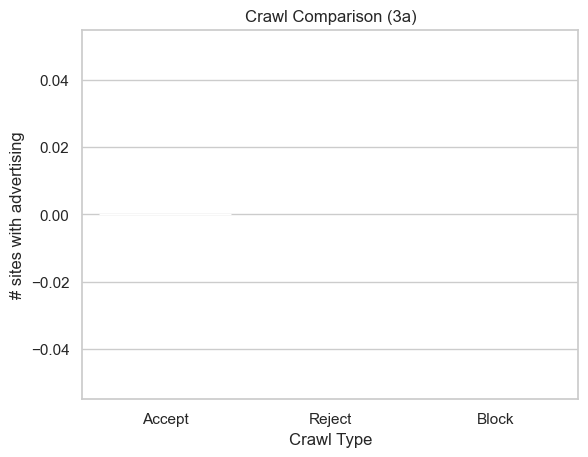

In [30]:
# 3a

visits_df, requests_df = load_results(RESULTS_PATH)
label_map = {"accept": "Accept", "reject": "Reject", "block": "Block"}
visits_df = visits_df.assign(crawl_label=visits_df["crawl_mode"].map(label_map))

advertising_visits = (
    requests_df[requests_df["disconnect_category"] == "Advertising"]["visit_id"]
    .dropna()
    .unique()
)
summary = (
    visits_df.assign(has_advertising=visits_df["visit_id"].isin(advertising_visits))
    .groupby("crawl_label")["has_advertising"]
    .sum()
    .reindex(["Accept", "Reject", "Block"])
    .rename("# sites with advertising")
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x=summary.index,
    y=summary.values,
    palette=["#4C72B0", "#DD8452", "#55A868"],
)
ax.set_xlabel("Crawl Type")
ax.set_ylabel("# sites with advertising")
ax.set_title("Crawl Comparison (3a)")
plt.show()

C:\Users\telle\AppData\Local\Temp\ipykernel_20632\1460353194.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


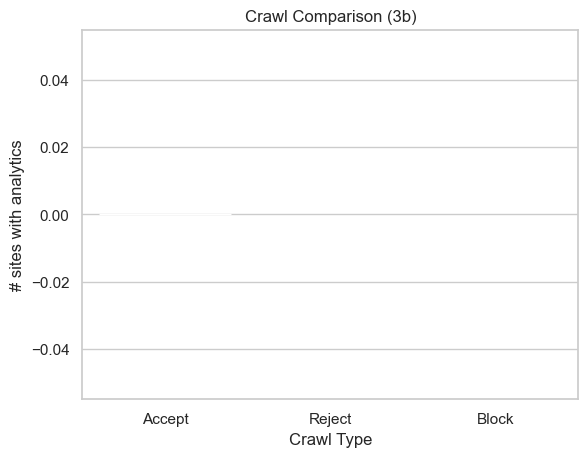

In [31]:
# 3b
visits_df, requests_df = load_results(RESULTS_PATH)
label_map = {"accept": "Accept", "reject": "Reject", "block": "Block"}
visits_df = visits_df.assign(crawl_label=visits_df["crawl_mode"].map(label_map))

analytics_visits = (
    requests_df[requests_df["disconnect_category"] == "Analytics"]["visit_id"]
    .dropna()
    .unique()
)
summary = (
    visits_df.assign(has_analytics=visits_df["visit_id"].isin(analytics_visits))
    .groupby("crawl_label")["has_analytics"]
    .sum()
    .reindex(["Accept", "Reject", "Block"])
    .rename("# sites with analytics")
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x=summary.index,
    y=summary.values,
    palette=["#4C72B0", "#DD8452", "#55A868"],
)
ax.set_xlabel("Crawl Type")
ax.set_ylabel("# sites with analytics")
ax.set_title("Crawl Comparison (3b)")
plt.show()

In [32]:
# 4
visits_all, _ = load_results(RESULTS_PATH)
visits_all = visits_all.assign(
    distinct_entities=visits_all["disconnect_category_counts"].apply(
        lambda d: len(d) if isinstance(d, dict) else 0
    )
)

metrics = {
    "total_requests": "Number of requests per website",
    "third_party_requests": "Number of third-party requests per website",
    "unique_domains_third_party": "Number of distinct third-party domains per website",
    "distinct_entities": "Number of distinct Disconnect entities per website",
}
for col in metrics:
    visits_all[col] = pd.to_numeric(visits_all[col], errors="coerce")

us_countries = {"US"}
eu_countries = {"DE", "FR", "NL", "BE", "ES", "IT", "PT", "SE", "DK", "NO", "FI", "IE", "AT", "CH"}

accept_df = visits_all[visits_all["crawl_mode"] == "accept"].copy()
accept_df["region"] = accept_df["country"].str.upper().map(
    lambda c: "US News Sites" if c in us_countries else ("European News Sites" if c in eu_countries else None)
)

stats = ["min", "median", "max"]
summary_us_eu = (
    accept_df.dropna(subset=["region"])
    .groupby("region")[list(metrics.keys())]
    .agg(stats) # type: ignore
    .rename_axis(index="Metric group")
    .transpose()
)

summary_us_eu.index = [
    f"{metrics[col]} – {stat.title()}" for col, stat in summary_us_eu.index
]
regions = ["US News Sites", "European News Sites"]
summary_us_eu = summary_us_eu.reindex(columns=regions)
summary_us_eu.loc[:, regions]

Metric group,US News Sites,European News Sites
Number of requests per website – Min,488.0,82.0
Number of requests per website – Median,488.0,280.0
Number of requests per website – Max,488.0,831.0
Number of third-party requests per website – Min,375.0,35.0
Number of third-party requests per website – Median,375.0,80.0
Number of third-party requests per website – Max,375.0,620.0
Number of distinct third-party domains per website – Min,123.0,12.0
Number of distinct third-party domains per website – Median,123.0,34.0
Number of distinct third-party domains per website – Max,123.0,178.0
Number of distinct Disconnect entities per website – Min,0.0,0.0


C:\Users\telle\AppData\Local\Temp\ipykernel_20632\3236597340.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


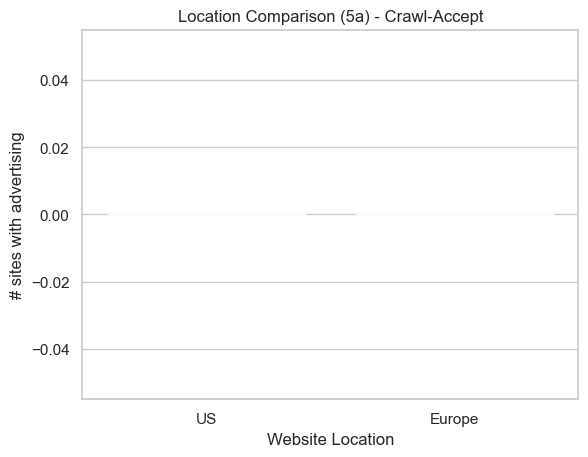

In [33]:
# 5a
visits_accept, requests_accept = load_results(RESULTS_PATH)
visits_accept = visits_accept.assign(
    distinct_entities=visits_accept["disconnect_category_counts"].apply(
        lambda d: len(d) if isinstance(d, dict) else 0
    )
)

us_countries = {"US"}
eu_countries = {"DE", "FR", "NL", "BE", "ES", "IT", "PT", "SE", "DK", "NO", "FI", "IE", "AT", "CH"}

accept_only = visits_accept[visits_accept["crawl_mode"] == "accept"].copy()
accept_only["region"] = accept_only["country"].str.upper().map(
    lambda c: "US" if c in us_countries else ("Europe" if c in eu_countries else None)
)

advertising_visits_accept = (
    requests_accept[
        (requests_accept["crawl_mode"] == "accept")
        & (requests_accept["disconnect_category"] == "Advertising")
    ]["visit_id"]
    .dropna()
    .unique()
)

summary_5a = (
    accept_only.assign(has_ads=accept_only["visit_id"].isin(advertising_visits_accept))
    .dropna(subset=["region"])
    .groupby("region")["has_ads"]
    .sum()
    .reindex(["US", "Europe"])
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x=summary_5a.index,
    y=summary_5a.values,
    palette=["#4C72B0", "#DD8452"],
)
ax.set_xlabel("Website Location")
ax.set_ylabel("# sites with advertising")
ax.set_title("Location Comparison (5a) - Crawl-Accept")
plt.show()

C:\Users\telle\AppData\Local\Temp\ipykernel_20632\4196949626.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


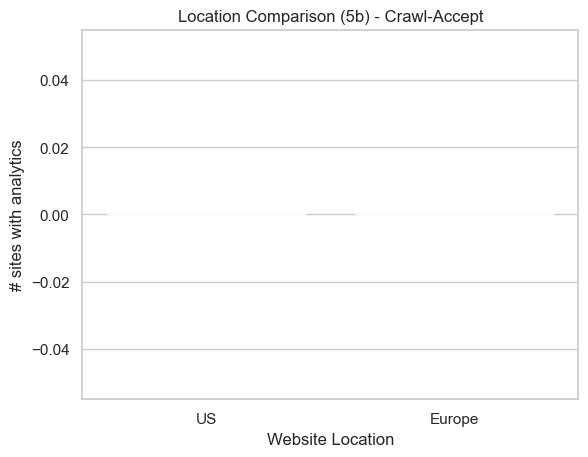

In [34]:
# 5b
visits_accept, requests_accept = load_results(RESULTS_PATH)

us_countries = {"US"}
eu_countries = {"DE", "FR", "NL", "BE", "ES", "IT", "PT", "SE", "DK", "NO", "FI", "IE", "AT", "CH"}

accept_only = visits_accept[visits_accept["crawl_mode"] == "accept"].copy()
accept_only["region"] = accept_only["country"].str.upper().map(
    lambda c: "US" if c in us_countries else ("Europe" if c in eu_countries else None)
)

analytics_visits_accept = (
    requests_accept[
        (requests_accept["crawl_mode"] == "accept")
        & (requests_accept["disconnect_category"] == "Analytics")
    ]["visit_id"]
    .dropna()
    .unique()
)

summary_5b = (
    accept_only.assign(has_analytics=accept_only["visit_id"].isin(analytics_visits_accept))
    .dropna(subset=["region"])
    .groupby("region")["has_analytics"]
    .sum()
    .reindex(["US", "Europe"])
)

sns.set_theme(style="whitegrid")
ax = sns.barplot(
    x=summary_5b.index,
    y=summary_5b.values,
    palette=["#4C72B0", "#DD8452"],
)
ax.set_xlabel("Website Location")
ax.set_ylabel("# sites with analytics")
ax.set_title("Location Comparison (5b) - Crawl-Accept")
plt.show()

In [ ]:
# 6
# Load the cookie write logs captured during the Accept crawl.
COOKIE_LOG_DIR = (pathlib.Path.cwd() / ".." / "crawl_data_accept").resolve()

if not COOKIE_LOG_DIR.exists():
    raise FileNotFoundError(f"No cookie log directory at {COOKIE_LOG_DIR}")

# Parse each document.cookie assignment to recover the cookie name and optional domain.
def parse_cookie_assignment(value: str) -> tuple[str | None, str | None]:
    parts = [part.strip() for part in value.split(";")]
    if not parts or "=" not in parts[0]:
        return None, None
    name = parts[0].split("=", 1)[0].strip() or None
    domain_attr = None
    for part in parts[1:]:
        if part.lower().startswith("domain="):
            domain_attr = part.split("=", 1)[1].strip() or None
            break
    return name, domain_attr

client_cookie_rows: list[dict[str, str]] = []

# Traverse every cookie log, extract the assignments, and store normalized rows.
for path in COOKIE_LOG_DIR.glob("*_cookie_writes.json"):
    data = json.loads(path.read_text(encoding="utf-8"))
    site_host = data.get("domain") or path.stem.removesuffix("_cookie_writes")
    # Method: use the instrumented document.cookie records captured during the Accept crawl.
    for entry in data.get("writes", []):
        if not isinstance(entry, dict) or not isinstance(entry.get("value"), str):
            continue
        name, domain_attr = parse_cookie_assignment(entry["value"])
        if not name:
            continue
        client_cookie_rows.append(
            {
                "Cookie name": name,
                "Website": site_host,
                "Cookie domain": domain_attr or site_host,
            }
        )

client_cookie_df = pd.DataFrame(
    client_cookie_rows,
    columns=["Cookie name", "Website", "Cookie domain"],
).drop_duplicates()

if not client_cookie_df.empty:
    client_cookie_df = client_cookie_df.sort_values(["Website", "Cookie name"]).reset_index(drop=True)

client_cookie_df

,Cookie name,Website,Cookie domain
0,_ga,ad.nl,ad.nl
1,_ga_DN0P5D59BT,ad.nl,ad.nl
2,_gcl_au,ad.nl,ad.nl
3,_gd1762772881175_sharedId,ad.nl,www.ad.nl
4,_gd1762772881175_sharedId,ad.nl,ad.nl
...,...,...,...
382,cto_writeable,telegraaf.nl,.telegraaf.nl
383,cto_writeable,telegraaf.nl,.www.telegraaf.nl
384,didomi_token,telegraaf.nl,telegraaf.nl
385,dsy-color-mode,telegraaf.nl,telegraaf.nl


In [41]:
# 7
from urllib.parse import urlparse

visits_df, requests_df = load_results(RESULTS_PATH)

# Method: derive third-party hosts from request URLs and aggregate distinct websites per crawl mode.
third_party = requests_df[requests_df["is_third_party"].fillna(False)].copy()
third_party["hostname"] = third_party["url"].map(lambda u: urlparse(u).hostname if isinstance(u, str) else None)
third_party = third_party.dropna(subset=["hostname", "visit_id", "crawl_mode"])

label_map = {"accept": "Crawl-Accept", "reject": "Crawl-Reject", "block": "Crawl-Block"}
tables: dict[str, pd.DataFrame] = {}

for mode, label in label_map.items():
    subset = third_party[third_party["crawl_mode"] == mode]
    grouped = (
        subset.groupby("hostname")
        .agg(
            distinct_websites=("visit_id", pd.Series.nunique),
            disconnect_categories=("disconnect_category", lambda cats: ", ".join(sorted({c for c in cats if c})) or "NA"),
        )
        .reset_index()
        .rename(
            columns={
                "hostname": "Third-party domain",
                "distinct_websites": "Number of distinct websites",
                "disconnect_categories": "Disconnect categories",
            }
        )
        .sort_values("Number of distinct websites", ascending=False)
        .head(10)
    )
    tables[label] = grouped

tables["Crawl-Accept"], tables["Crawl-Reject"], tables["Crawl-Block"]

(                 Third-party domain  Number of distinct websites  \
 532        www.googletagmanager.com                            9   
 424  securepubads.g.doubleclick.net                            9   
 253                    ib.adnxs.com                            9   
 529                  www.google.com                            9   
 345   pagead2.googlesyndication.com                            9   
 218     ep2.adtrafficquality.google                            8   
 217     ep1.adtrafficquality.google                            8   
 246                  gum.criteo.com                            7   
 299                match.adsrvr.org                            6   
 481       tpc.googlesyndication.com                            6   
 
     Disconnect categories  
 532                    NA  
 424                    NA  
 253                    NA  
 529                    NA  
 345                    NA  
 218                    NA  
 217                    NA  
 246   